# Signal loss

An example of the signal loss calculation for a very-low-noise, coupling-mitigated cross-correlation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import arviz as az

import pymc3 as pm

import theano.tensor as T

from scipy.signal import windows
from numpy.fft import fft, fftshift, ifftshift
from astropy import units

from Delay_Transform import gen_window
from Delay_Transform import fourier_freqs
from Delay_Transform import FFT

from Systematics_Functions import Auto_Systematics, Auto_Systematics_No_T, Auto_Subtract, Cross_Systematics, Cross_Systematics_No_T

In [2]:
def Fourier_Transform(freqs,data,freq_taper):

    plot_units = {
        "lst": "hour",
        "time": "day",
        "freq": "MHz",
        "fringe-rate": "mHz",
        "delay": "ns"
    }
    

    scale_factor = 1 # Get FFT data units right.
    
    scale_factor *= np.mean(np.diff(freqs)) # Hz
    delays = fourier_freqs(freqs) * units.s.to(plot_units["delay"])
    data = np.atleast_2d(data)
    data = FFT(data, axis=1, taper=freq_taper)

    
    #Delay Space
    data *= scale_factor
    
    return([delays,data])

In [3]:
'''Power spectrum plotter'''

def Delay_Plot(FT_Data, label, color, linestyle):
    plt.plot(FT_Data[0], np.abs(FT_Data[1][0]*np.conj(FT_Data[1][0])),
             linewidth=1.25, label=label, color=color, linestyle=linestyle)

    plt.legend(frameon=False)
    plt.yscale('log')
    plt.xlim(-500,2000)
    #plt.ylim(1e1,5e17)
    plt.xlabel('$\\tau$ [ns]',fontsize=12)
    plt.ylabel('|$\\rm{V}_{\\rm{ab}}$|$^2$($\\nu$) [Jy Hz]$^2$',fontsize=12)
    plt.tight_layout()

In [4]:
'''Use the same data as in Coupling_Sampler.ipynb'''

Data = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.1.2.COUPLING.npy')[:,75:587]
freqs = np.load("example_data/freqs.npy", allow_pickle=True)[0][75:587]

Data_FT = Fourier_Transform(freqs,Data,'blackman-harris')

In [5]:
'''Load the relevant components (foreground eigenvectors, etc.)'''

#Vectorise the autos to keep with the convention for pymc3, even though it should be fully real
Auto_1 = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.1.1.COUPLING.npy')[0][75:587]
Auto_1=[Auto_1.real,Auto_1.imag]
Auto_2 = np.load('example_data/coupling_sampling/zen.2458098.26719.sum.corrupt.2.2.COUPLING.npy')[0][75:587]
Auto_2=[Auto_2.real,Auto_2.imag]

'''Assume very low noise'''
dt = 10.73 * 1e6 #Integration time in seconds
freq_width = freqs[1] - freqs[0] #Frequency channel width in Hz

sigma = np.sqrt(np.abs((Auto_1[0])*(Auto_2[0]))/(dt*freq_width))

#Form the complex noise visibility
sigma_comp = (sigma*np.random.normal(loc=0.0, scale=1, size=512)/np.sqrt(2) + 1j*sigma*np.random.normal(loc=0.0, scale=1, size=512)/np.sqrt(2))
sigma_comp_FT = Fourier_Transform(freqs,sigma_comp,'blackman-harris')


#Y = np.column_stack([Data.real + sigma_comp.real, Data.imag + sigma_comp.imag])
Y = Data + sigma_comp
Y_FT = Fourier_Transform(freqs,Y,'blackman-harris')

FG_Evecs = np.load('components/FG_evecs_cross.npy') #Foreground eigenvectors

EoR_FModes = np.load('components/EoR_fModes_cross.npy') #Signal Fourier modes

#Vectorise for the sampler
FG_Evecs_Split = [FG_Evecs.real, FG_Evecs.imag]
EoR_FModes_Split = [EoR_FModes.real, EoR_FModes.imag]

cc_Ncopies = 10

N_EoR_Modes = 199
N_FG_Evecs = 100

In [6]:
'''Load a trace run on this low noise case - converted to npy file to save space'''
###trace = az.from_netcdf("traces/1_2_trace_no_noise.nc")
trace = np.load('traces/1_2_trace_no_noise.npy',allow_pickle=True).item()

In [7]:
#This for .nc traces
'''N_samples = np.shape(trace.posterior['cc_amps_scaled'])[1]

#Get the model results for the parameters
cc_amps_result=np.array(trace.posterior['cc_amps_scaled'][1])

cc_dlys_pos_result=np.array(trace.posterior['cc_dlys_pos_scaled'][1])

cc_phs_result=np.array(trace.posterior['cc_phs'][1])

FGAmps_real_result=np.array(trace.posterior['FGAmps_real'][1])

FGAmps_imag_result=np.array(trace.posterior['FGAmps_imag'][1])

EORFAmps_result=np.array(trace.posterior['EORFAmps'][1])'''

#This for traces converted to dicts/.npy files
N_samples = np.shape(trace['cc_amps_scaled'])[1]

#Get the model results for the parameters
cc_amps_result=np.array(trace['cc_amps_scaled'][1])

cc_dlys_pos_result=np.array(trace['cc_dlys_pos_scaled'][1])

cc_phs_result=np.array(trace['cc_phs'][1])

FGAmps_real_result=np.array(trace['FGAmps_real'][1])

FGAmps_imag_result=np.array(trace['FGAmps_imag'][1])

#EORFAmps_result=np.array(trace['EORFAmps'][1])

### Plots

Plot some of the sampling results

In [8]:
'''Form an array containing visibilities corresponding to all samples, i.e. one step
    in the chain becomes one visibility'''

Model_Results_All = []

for qq in range(0,N_samples):
    
    #Print some sort of progress
    if qq % 1000 == 0:
            print(str(qq) + '/' + str(N_samples),end=' ')
    
    Model_Results = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq], cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)

    
    Model_Results_complex = Model_Results[:,0] + Model_Results[:,1]*1j
    
    Model_Results_FT = Fourier_Transform(freqs,Model_Results_complex,'blackman-harris')

    
    Model_Results_All.append(Model_Results_FT[1][0])
    
Model_Results_All = np.array(Model_Results_All)

0/20000 1000/20000 2000/20000 3000/20000 4000/20000 5000/20000 6000/20000 7000/20000 8000/20000 9000/20000 10000/20000 11000/20000 12000/20000 13000/20000 14000/20000 15000/20000 16000/20000 17000/20000 18000/20000 19000/20000 

In [9]:
'''Find the 95th percentile of the model visibilities'''

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Model_Results_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Model_Results_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Model_Results_All.T[vv]), 5, axis=0))

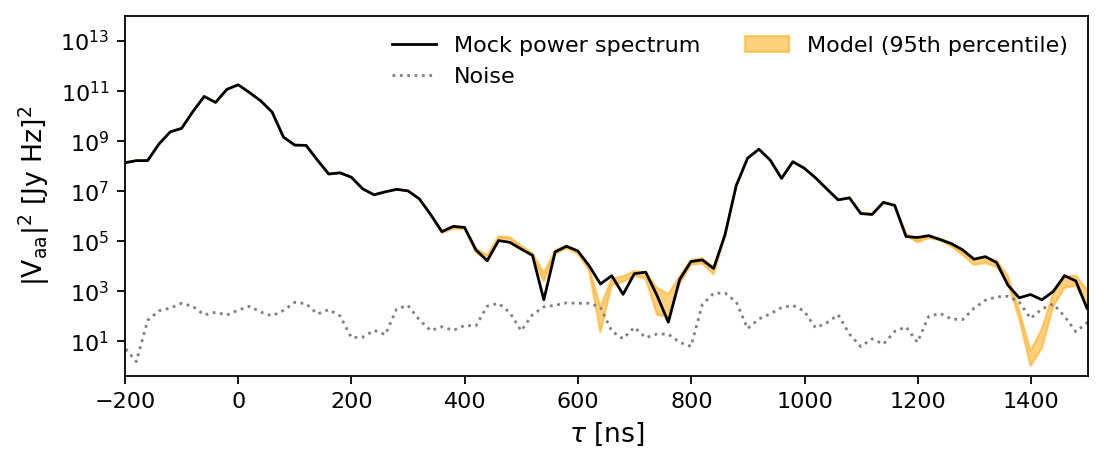

In [10]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)

Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')
#Delay_Plot(Data_Gains_FT, 'True power spectrum', 'green', '--')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(
    perc_95*np.conj(perc_95)),
                    color='orange',linewidth=1,alpha=0.5,label='Model (95th percentile)')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(4e-1,1e14)
#plt.axvline(940)
plt.legend(frameon=False,ncol=2)

plt.ylabel('|V$_{\\rm{aa}}$|$^2$ [Jy Hz]$^2$',fontsize=12)

plt.xlabel('$\\tau$ [ns]',fontsize=12)
fig.tight_layout()


In [11]:
Chain_Results_FT_All = []

for qq in range(0,N_samples):
    
    if qq % 1000 == 0:
        print(str(qq) + '/' + str(N_samples),end=' ')
        
    #Form the model power spectra
    Model_Results = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq], cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)
    
    
    #Form foreground+EoR models only (leave out CC)
    Model_Results_FG_EOR = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq]*0, cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)
    
    
    #Form the cross-coupling-only visibilities, then subtract this from the mock data
    CC_complex = Model_Results[:,0] + Model_Results[:,1]*1j - Model_Results_FG_EOR[:,0] - Model_Results_FG_EOR[:,1]*1j
    SysCheck_complex = (Data + sigma_comp) - CC_complex


    #FT the recovered visibilities
    Chain_Results_FT = Fourier_Transform(freqs,SysCheck_complex,'blackman-harris')
    Chain_Results_FT_All.append(Chain_Results_FT[1][0])

Chain_Results_FT_All = np.array(Chain_Results_FT_All)

0/20000 1000/20000 2000/20000 3000/20000 4000/20000 5000/20000 6000/20000 7000/20000 8000/20000 9000/20000 10000/20000 11000/20000 12000/20000 13000/20000 14000/20000 15000/20000 16000/20000 17000/20000 18000/20000 19000/20000 

In [12]:
'''Find the 95th percentile of the recovered visibilities'''

mean = []
perc_95 = []
perc_5 = []

for vv in range(0,512):
    mean.append(np.mean(np.abs(Chain_Results_FT_All.T[vv])))
    perc_95.append(np.percentile(np.abs(Chain_Results_FT_All.T[vv]), 95, axis=0))
    perc_5.append(np.percentile(np.abs(Chain_Results_FT_All.T[vv]), 5, axis=0))

In [13]:
Data_True = np.load('example_data/reflection_sampling/zen.2458098.26719.sum.corrupt.1.2.GAINS.npy')[:,75:587]
Data_True_FT = Fourier_Transform(freqs,Data_True,'blackman-harris')

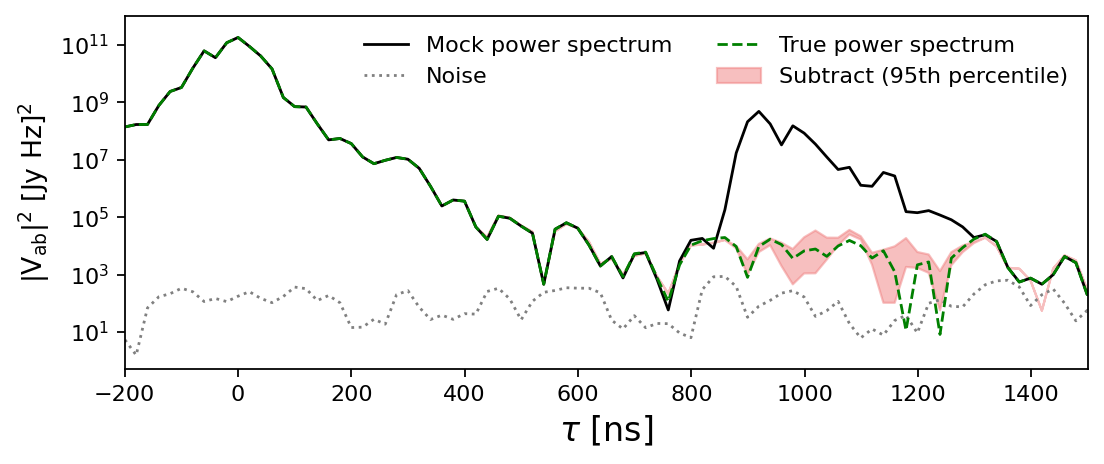

In [14]:
fig, axs = plt.subplots(figsize=(7,3),dpi=160)
Delay_Plot(Data_FT, 'Mock power spectrum', 'k', '-')
Delay_Plot(sigma_comp_FT, 'Noise', 'grey', ':')

plt.fill_between(Data_FT[0],np.abs(perc_5*np.conj(perc_5)),np.abs(perc_95*np.conj(perc_95)),color='lightcoral',linewidth=1,
                 alpha=0.5,label='Subtract (95th percentile)')

Delay_Plot(Data_True_FT, 'True power spectrum', 'green', '--')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(0.5e0,1e12)
#plt.axvline(940)
plt.legend(frameon=False,loc='upper right',ncol=2)

plt.ylabel('|V$_{\\rm{ab}}$|$^2$ [Jy Hz]$^2$',fontsize=12)


plt.xlabel('$\\tau$ [ns]',fontsize=15)

fig.tight_layout()


### Signal loss

In [15]:
'''
Find the cross-coupling-only visibilities for all samples. Just form
the model visibilities, and the foreground + EoR visibilities, and subtract 
the two.
'''
cc_only_all = [] 

for qq in range(0,N_samples):
    if qq % 1000 == 0:
            print(str(qq) + '/' + str(N_samples),end=' ')
    
    fg_eor_only = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq]*0, cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)

    cc_only = Cross_Systematics_No_T(refl_amp=0,refl_dly=0,refl_phs=0,
                cc_amps=cc_amps_result[qq], cc_dlys_pos=cc_dlys_pos_result[qq], cc_dlys_neg=0, cc_phs=cc_phs_result[qq],
                subreflAmps=0, subreflDlys=0, subreflPhses=0,
                FGAmps_real=FGAmps_real_result[qq],FGAmps_imag=FGAmps_imag_result[qq],FG_Evecs=FG_Evecs_Split,EORFAmps=[0],
                                  EOR_FModes=EoR_FModes_Split, freqs=freqs, cc_Ncopies=cc_Ncopies, NSubrefls=0,
                                  N_FAmps=N_EoR_Modes,N_FGAmps=N_FG_Evecs,autovis=Auto_1)
    
    cc_only_all.append(cc_only - fg_eor_only)
    
cc_only_all = np.array(cc_only_all)


0/20000 1000/20000 2000/20000 3000/20000 4000/20000 5000/20000 6000/20000 7000/20000 8000/20000 9000/20000 10000/20000 11000/20000 12000/20000 13000/20000 14000/20000 15000/20000 16000/20000 17000/20000 18000/20000 19000/20000 

In [16]:
'''
Find all the cross-coupling subtracted visibilities
for all samples, and for all times. I.e. each time
will have N = N_samples recovered visibilities
'''
CCorr_Sub_All = []

N_times = np.shape(Data)[0]

for pp in range(0,N_times):
    
    print(str(pp) + '/' + str(N_times),end=' ')
    
    Single_t_res = [] #The result for all samples when applied to a single time single time

    for dd in range(0,N_samples):

        Cross_Subtract = Y[pp] - (cc_only_all[:,:,0][dd]+cc_only_all[:,:,1][dd]*1j) #coupling subtracted visibility

        Subtract_FT = Fourier_Transform(freqs,Cross_Subtract,'blackman-harris')
        
        Single_t_res.append(Subtract_FT[1][0]*np.conj(Subtract_FT[1][0])) #Append the recovered power spectrum
        
    CCorr_Sub_All.append(Single_t_res) #Append all recovered power spectra for this particular time

CCorr_Sub_All = np.array(CCorr_Sub_All)

0/60 1/60 2/60 3/60 4/60 5/60 6/60 7/60 8/60 9/60 10/60 11/60 12/60 13/60 14/60 15/60 16/60 17/60 18/60 19/60 20/60 21/60 22/60 23/60 24/60 25/60 26/60 27/60 28/60 29/60 30/60 31/60 32/60 33/60 34/60 35/60 36/60 37/60 38/60 39/60 40/60 41/60 42/60 43/60 44/60 45/60 46/60 47/60 48/60 49/60 50/60 51/60 52/60 53/60 54/60 55/60 56/60 57/60 58/60 59/60 

In [17]:
#Form the power spectra for the true data

PS_CCorr_True_FT = []

for nn in range(0,N_times):
    PS_CCorr_True_FT.append(Data_True_FT[1][nn]*np.conj(Data_True_FT[1][nn]))


In [18]:
#Find the time averaged power spectra for the true and recovered data
PS_CCorr_True_Av = np.mean(PS_CCorr_True_FT,axis=0)
PS_CCorr_sub_Av = np.mean(CCorr_Sub_All,axis=0)

In [19]:
#Find the signal loss metric (recovered/true) for all samples
R3_CCorr = np.abs(PS_CCorr_sub_Av)/np.abs(PS_CCorr_True_Av)

In [21]:
#Find the percentiles for all R3 samples
mean_R3 = []
perc_95_R3 = []
perc_5_R3 = []

for vv in range(0,512):
    mean_R3.append(np.mean(np.abs(R3_CCorr.T[vv])))
    perc_95_R3.append(np.percentile(np.abs(R3_CCorr.T[vv]), 95, axis=0))
    perc_5_R3.append(np.percentile(np.abs(R3_CCorr.T[vv]), 5, axis=0))

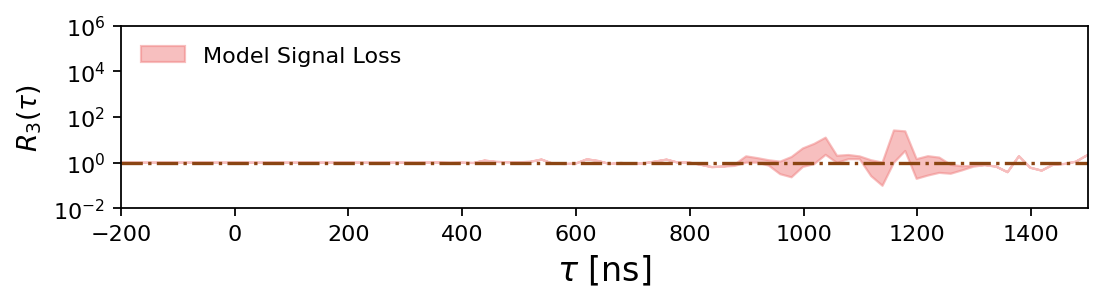

In [22]:
fig, axes = plt.subplots(figsize=(7,2),dpi=160)

plt.fill_between(Data_True_FT[0],np.abs(perc_5_R3),np.abs(perc_95_R3),color='lightcoral',linewidth=1,alpha=0.5,label='Model Signal Loss')

plt.axhline(1,color='saddlebrown',linestyle='-.')
plt.legend(frameon=False, loc='upper left')

plt.yscale('log')
plt.xlim(-200,1500)
plt.ylim(0.1e-1,1e6)
plt.xlabel('$\\tau$ [ns]',fontsize=15)
plt.ylabel('$R_3({\\tau})$',fontsize=12)

plt.tight_layout()